In [1]:
# 1. Выполните сохранение монохромного изображения в виде текстового или бинарного файла.
# 2. Реализуйте алгоритм вейвлет-преобразования Хаара для изображения.
# 3. Выполните квантование высокочастотных компонент (количество квантов = 4).
# 4. Сохраните получившийся массив значений в текстовый или бинарный файл.
#    Компоненты LH, HL, HH храните в виде пар (значение, количество повторений).
# 5. Сравните объем памяти, занимаемый исходным изображением (попиксельное хранение)
#    и изображением, полученным после преобразования Хаара и сжатием длин серий.


In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from collections import Counter


Монохромное изображение сохранено в файл: monochrome_image.txt


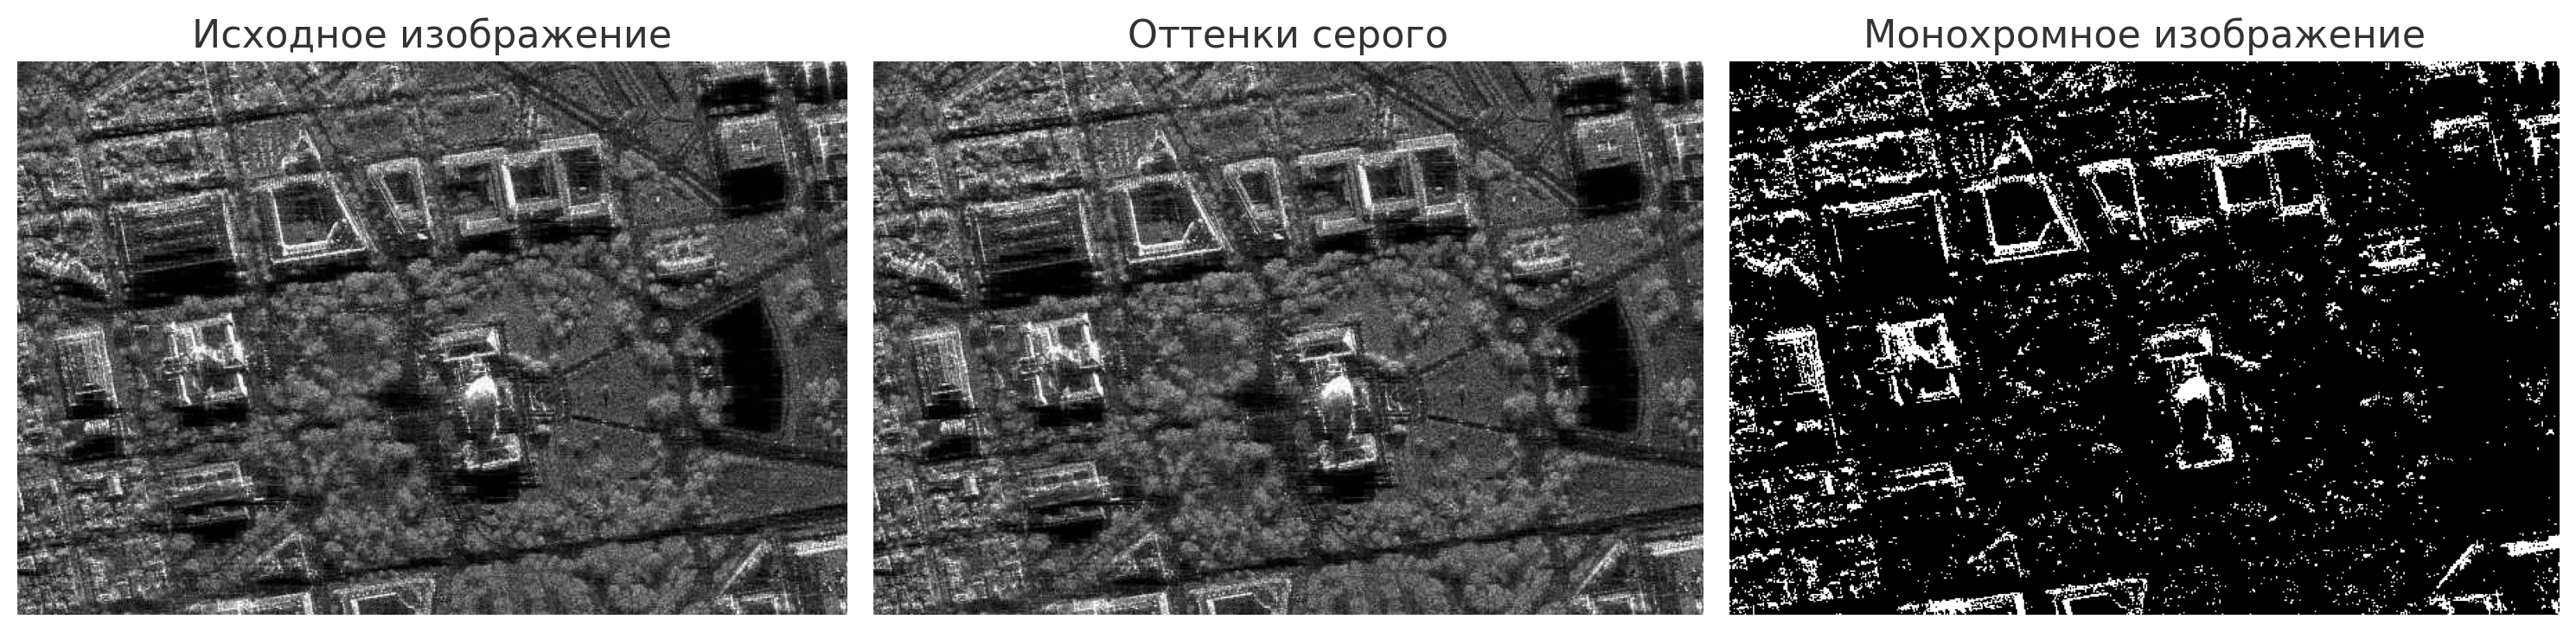

In [3]:
# 1. Загрузка изображения и сохранение монохромного варианта в текстовый файл

# Загружаем исходное изображение
image_data = cv.imread('sar_1_gray.jpg')
if image_data is None:
    raise FileNotFoundError('Файл sar_1_gray.jpg не найден. Поместите его в ту же папку, что и ноутбук.')

# Преобразуем к оттенкам серого (на случай, если изображение цветное)
gray_image = cv.cvtColor(image_data, cv.COLOR_BGR2GRAY)

# Пороговая бинаризация для получения монохромного (черно‑белого) изображения
threshold_value = 128
max_value = 255
_, monochrome_image = cv.threshold(gray_image, threshold_value, max_value, cv.THRESH_BINARY)

# Сохранение монохромного изображения в текстовый файл (попиксельно)
mono_filename = 'monochrome_image.txt'
with open(mono_filename, 'w', encoding='utf-8') as file:
    for row in monochrome_image:
        line = ' '.join(str(int(pixel)) for pixel in row)
        file.write(line + '\n')

print(f'Монохромное изображение сохранено в файл: {mono_filename}')

# Визуализация (не обязательно, но удобно для проверки)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(image_data, cv.COLOR_BGR2RGB))
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gray_image, cmap='gray')
plt.title('Оттенки серого')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(monochrome_image, cmap='gray')
plt.title('Монохромное изображение')
plt.axis('off')

plt.tight_layout()
plt.show()


LL shape: (200, 300)
LH shape: (200, 300)
HL shape: (200, 300)
HH shape: (200, 300)


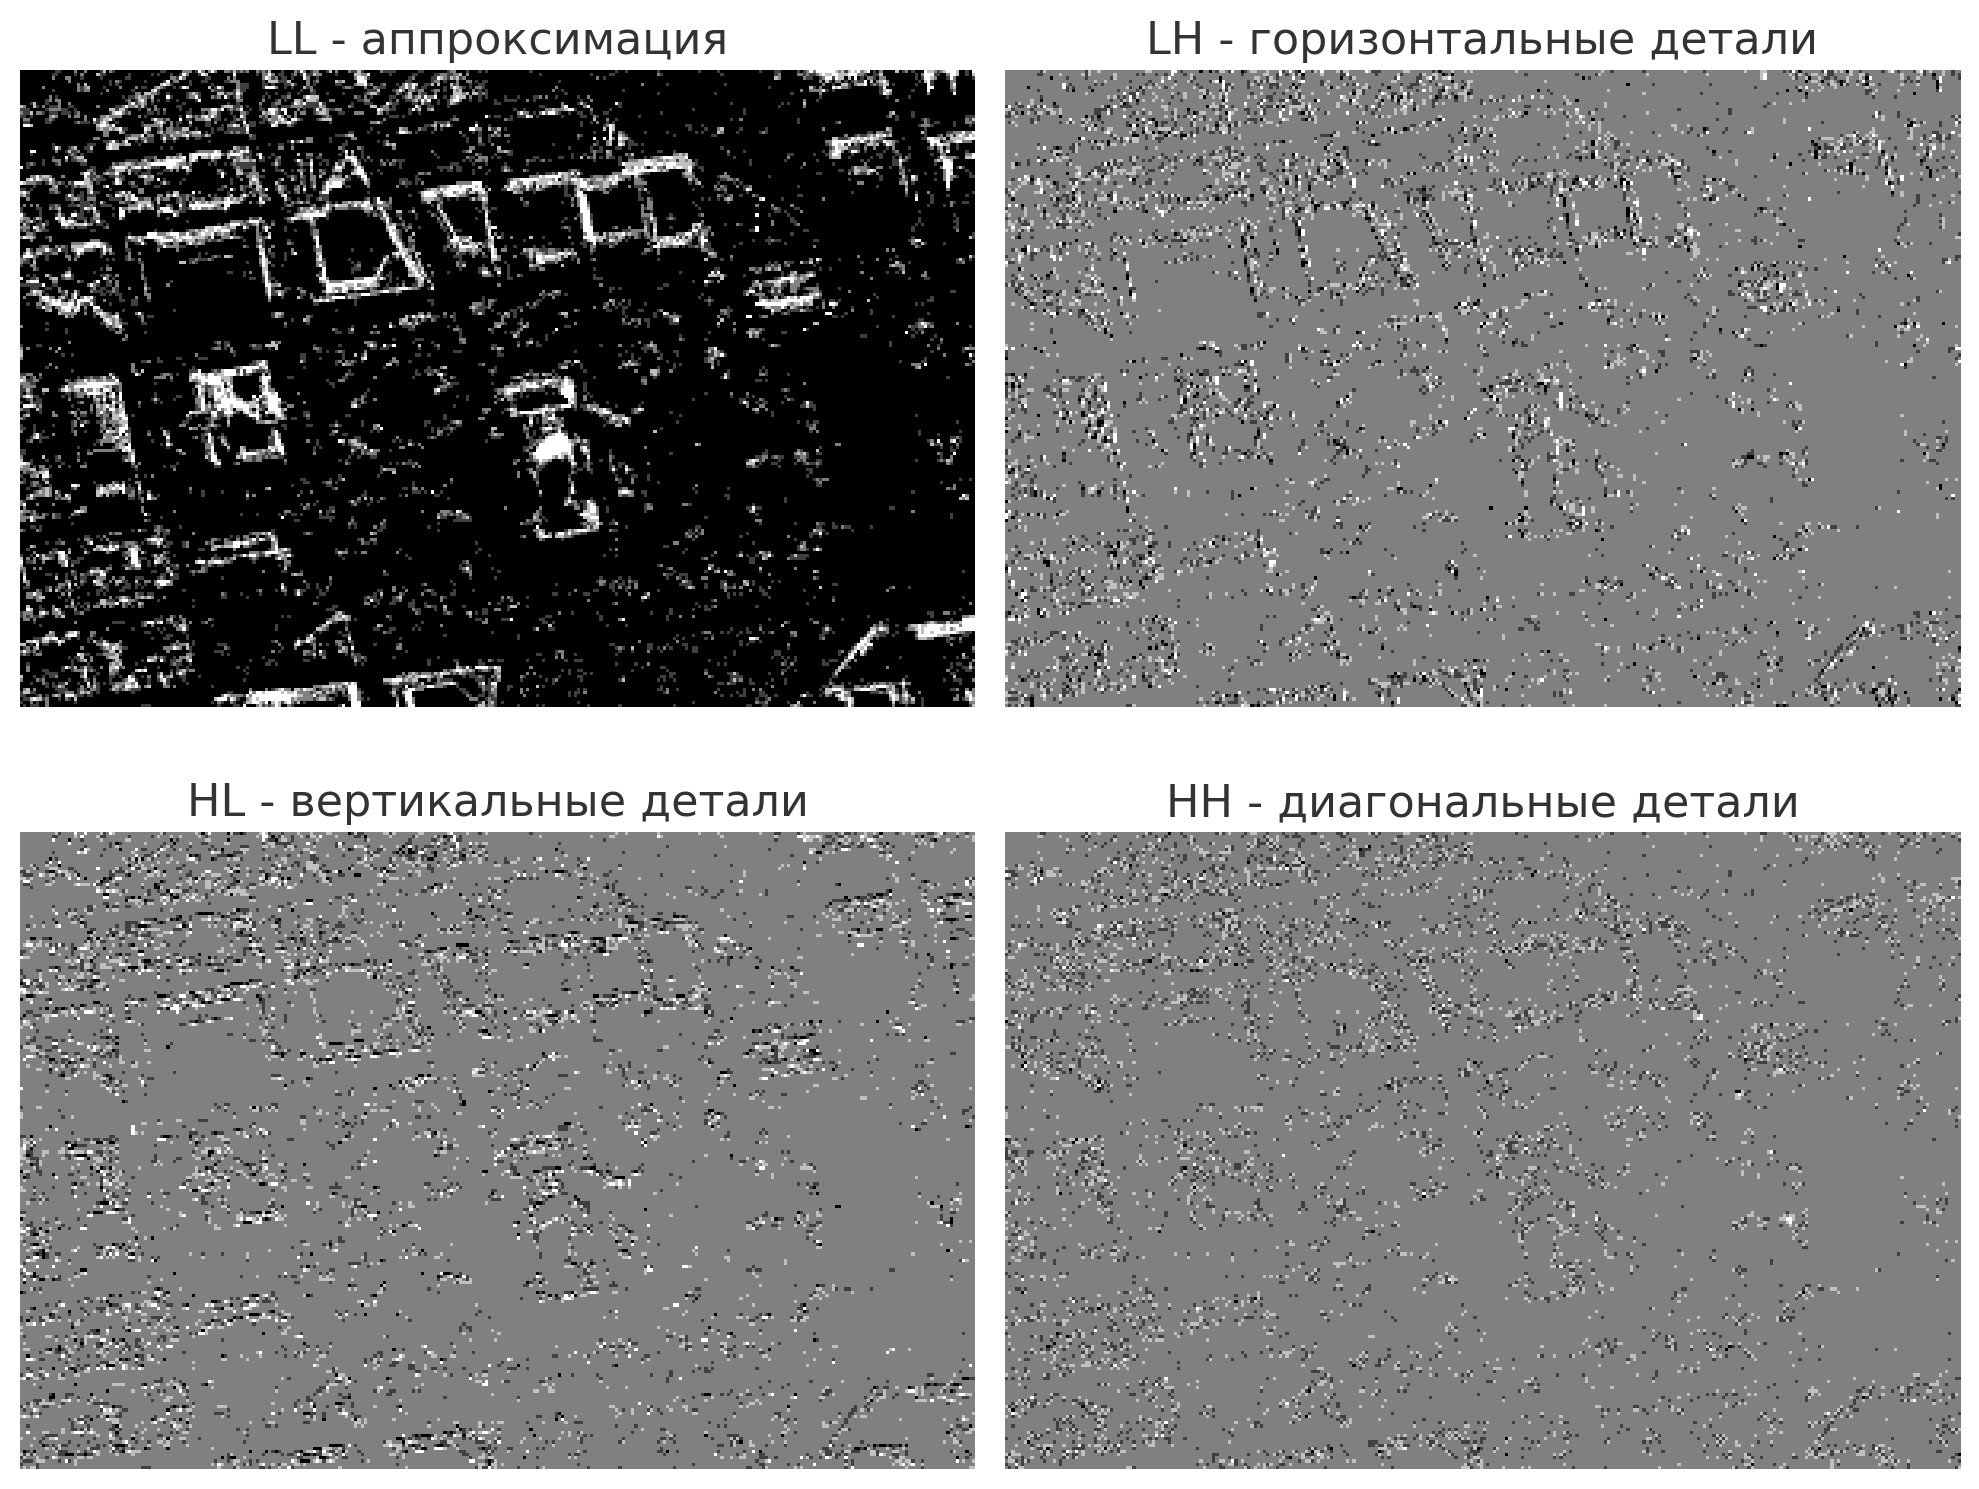

In [4]:
# 2. Реализация алгоритма вейвлет-преобразования Хаара (1 уровень)

def haar_wavelet_transform(img, level: int = 1):
    """Одно- или многоуровневое вейвлет-преобразование Хаара для 2D изображения."""
    image = img.astype(np.float64)
    transformed = image.copy()

    for current_level in range(level):
        h, w = transformed.shape
        if h < 2 or w < 2:
            break

        # Область, к которой применяем преобразование на текущем уровне
        current = transformed[:h, :w]

        # Преобразование по строкам
        row_transformed = np.zeros_like(current)
        half_w = w // 2
        for i in range(h):
            for j in range(0, w, 2):
                avg = (current[i, j] + current[i, j + 1]) / 2
                diff = (current[i, j] - current[i, j + 1]) / 2
                row_transformed[i, j // 2] = avg
                row_transformed[i, half_w + j // 2] = diff

        # Преобразование по столбцам
        col_transformed = np.zeros_like(row_transformed)
        half_h = h // 2
        for j in range(w):
            for i in range(0, h, 2):
                avg = (row_transformed[i, j] + row_transformed[i + 1, j]) / 2
                diff = (row_transformed[i, j] - row_transformed[i + 1, j]) / 2
                col_transformed[i // 2, j] = avg
                col_transformed[half_h + i // 2, j] = diff

        transformed[:h, :w] = col_transformed

    # Для 1 уровня разложение имеет вид:
    h, w = transformed.shape
    half_h, half_w = h // 2, w // 2
    ll = transformed[:half_h, :half_w]
    lh = transformed[:half_h, half_w:]
    hl = transformed[half_h:, :half_w]
    hh = transformed[half_h:, half_w:]

    return ll, lh, hl, hh

# Применяем преобразование Хаара к монохромному изображению
ll, lh, hl, hh = haar_wavelet_transform(monochrome_image, level=1)

print('LL shape:', ll.shape)
print('LH shape:', lh.shape)
print('HL shape:', hl.shape)
print('HH shape:', hh.shape)

# Визуализация коэффициентов (для наглядности)
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.imshow(ll, cmap='gray')
plt.title('LL - аппроксимация')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(lh, cmap='gray')
plt.title('LH - горизонтальные детали')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(hl, cmap='gray')
plt.title('HL - вертикальные детали')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(hh, cmap='gray')
plt.title('HH - диагональные детали')
plt.axis('off')

plt.tight_layout()
plt.show()


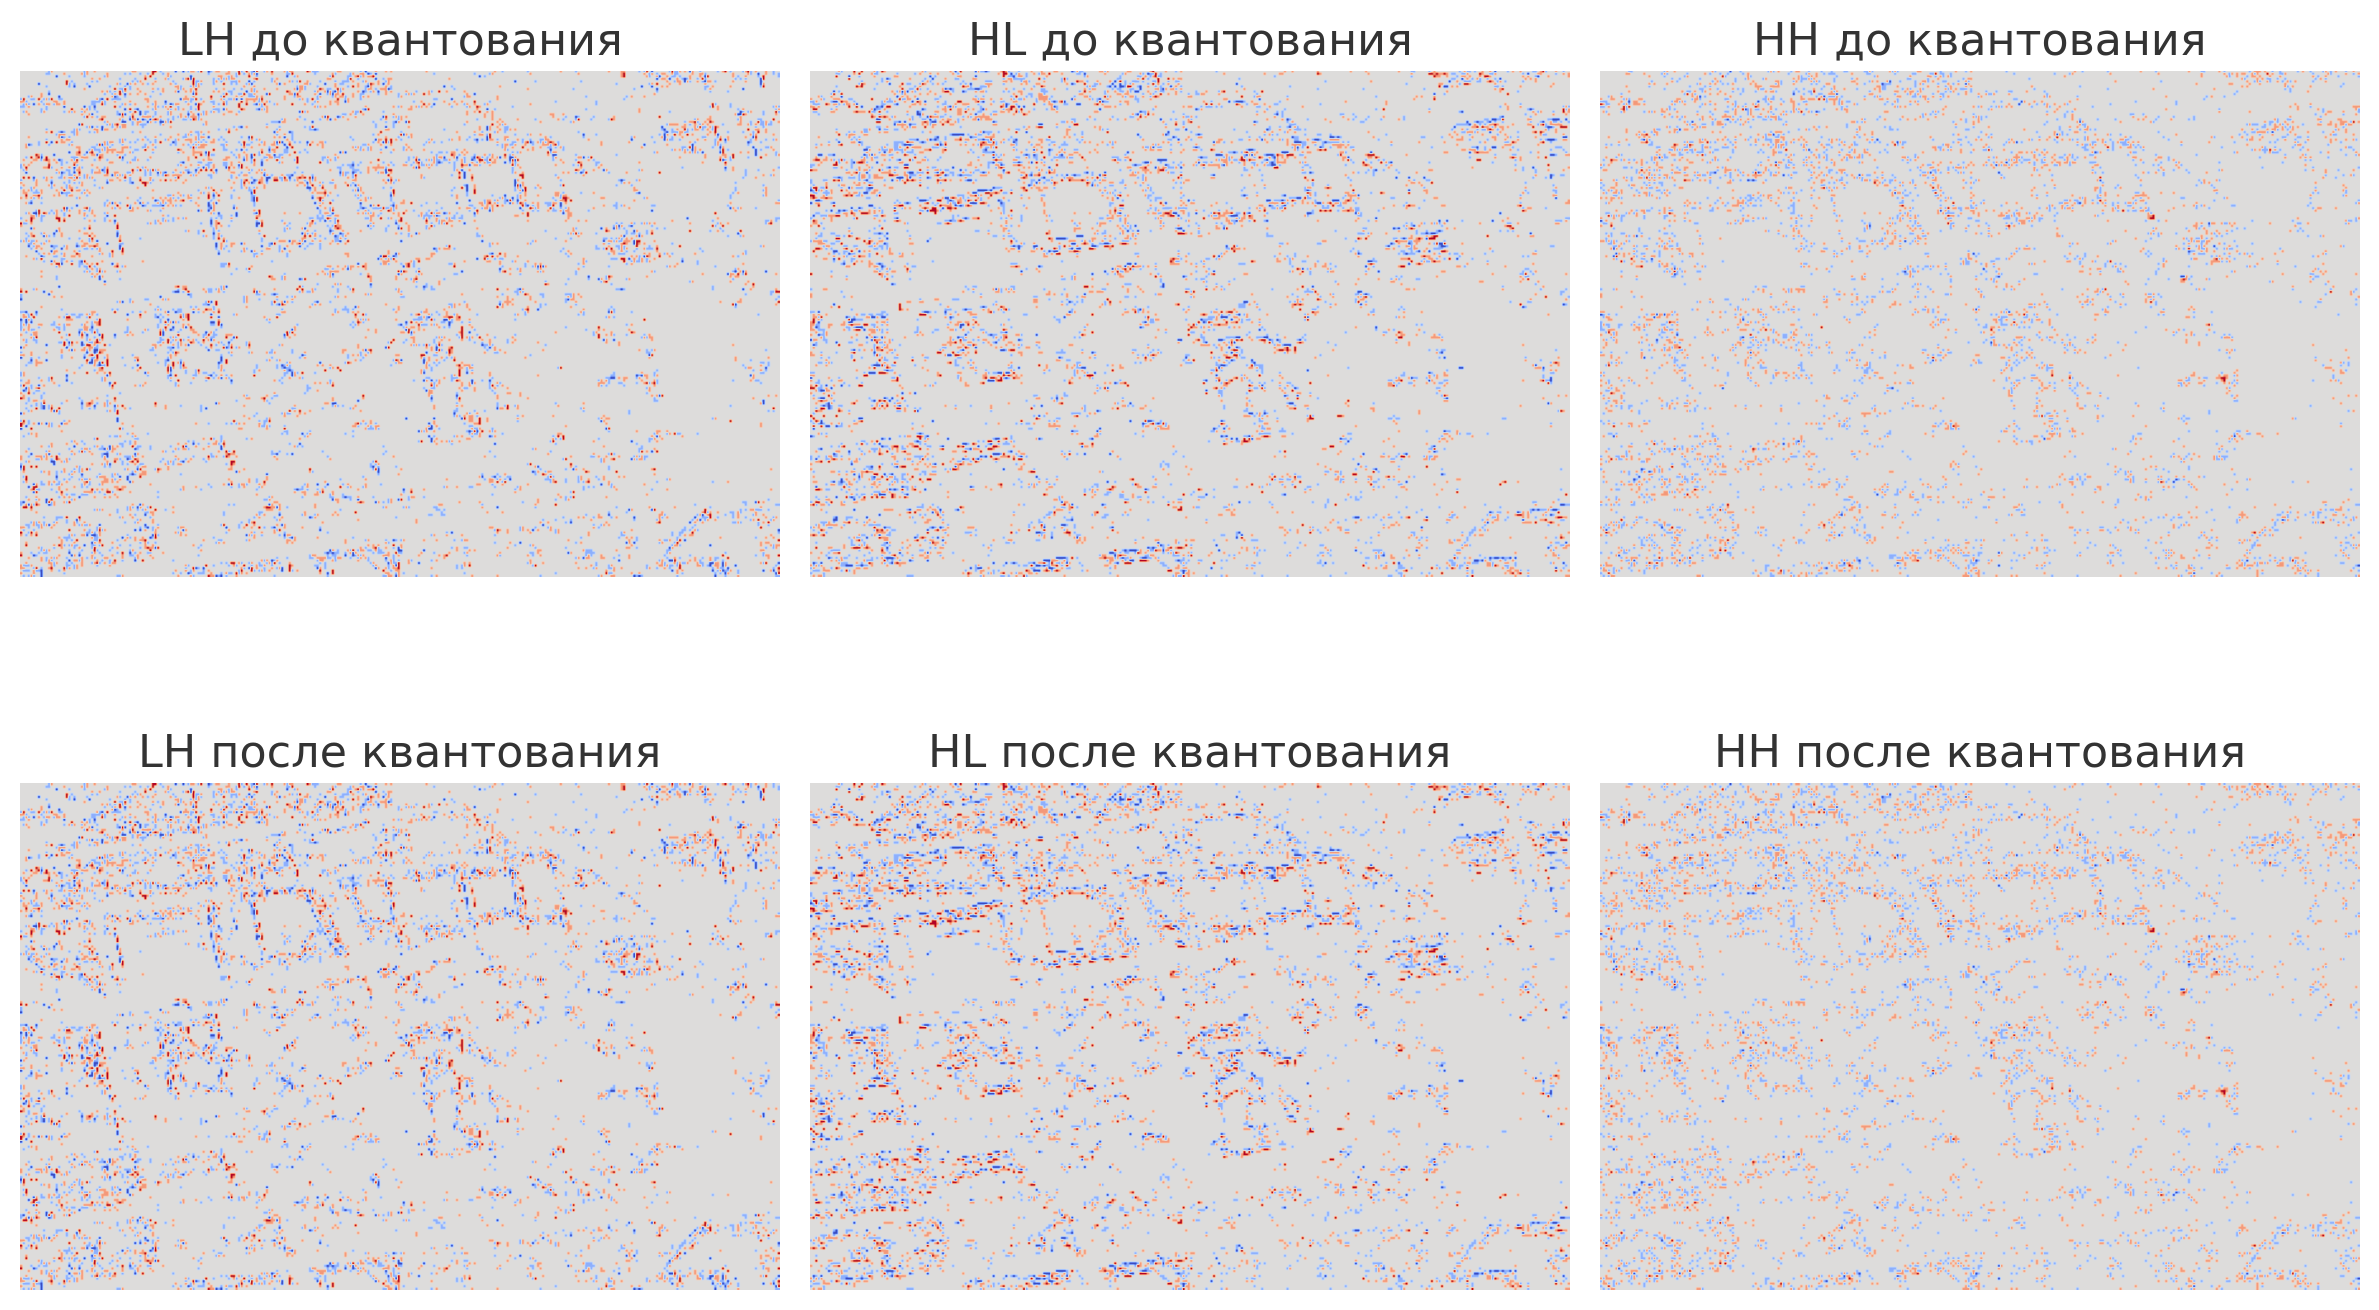

In [5]:
# 3. Квантование высокочастотных компонент (LH, HL, HH), количество квантов = 4

def quantize(coeffs: np.ndarray, n_quants: int):
    """Равномерное скалярное квантование массива коэффициентов."""
    min_val = np.min(coeffs)
    max_val = np.max(coeffs)
    step = (max_val - min_val) / n_quants
    # Код квантования: целые значения от 0 до n_quants
    quantized = np.round((coeffs - min_val) / step).astype(int)
    return quantized, min_val, step

num_quants = 4
lh_quant, lh_min, lh_step = quantize(lh, num_quants)
hl_quant, hl_min, hl_step = quantize(hl, num_quants)
hh_quant, hh_min, hh_step = quantize(hh, num_quants)

def dequantize(quantized: np.ndarray, min_val: float, step: float):
    """Обратное квантование (для проверки и визуализации)."""
    return min_val + quantized * step

# Восстановленные (приближенные) коэффициенты
lh_restored = dequantize(lh_quant, lh_min, lh_step)
hl_restored = dequantize(hl_quant, hl_min, hl_step)
hh_restored = dequantize(hh_quant, hh_min, hh_step)

# Визуальное сравнение до/после квантования
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1); plt.imshow(lh, cmap='coolwarm'); plt.title('LH до квантования'); plt.axis('off')
plt.subplot(2, 3, 2); plt.imshow(hl, cmap='coolwarm'); plt.title('HL до квантования'); plt.axis('off')
plt.subplot(2, 3, 3); plt.imshow(hh, cmap='coolwarm'); plt.title('HH до квантования'); plt.axis('off')
plt.subplot(2, 3, 4); plt.imshow(lh_restored, cmap='coolwarm'); plt.title('LH после квантования'); plt.axis('off')
plt.subplot(2, 3, 5); plt.imshow(hl_restored, cmap='coolwarm'); plt.title('HL после квантования'); plt.axis('off')
plt.subplot(2, 3, 6); plt.imshow(hh_restored, cmap='coolwarm'); plt.title('HH после квантования'); plt.axis('off')
plt.tight_layout()
plt.show()


In [6]:
# 4. Сохранение LL и RLE-кодированных LH, HL, HH в текстовый файл

def run_length_encode(data: np.ndarray):
    """Кодирование длин серий (упрощенный вариант с подсчетом повторений значений).
    
    Здесь используется Counter по значениям (частота появления значения в массиве),
    как в примере из лабораторной работы.
    """
    encoded = []
    for value, count in Counter(data.flatten()).items():
        encoded.append((int(value), int(count)))
    return encoded

lh_rle = run_length_encode(lh_quant)
hl_rle = run_length_encode(hl_quant)
hh_rle = run_length_encode(hh_quant)

haar_filename = 'haar_components.txt'
with open(haar_filename, 'w', encoding='utf-8') as file:
    # Сначала сохраняем LL как полную матрицу
    np.savetxt(file, ll, fmt='%d')
    file.write('\n')

    # Затем сохраняем квантованные компоненты в виде пар (значение, количество)
    components = [('LH', lh_rle), ('HL', hl_rle), ('HH', hh_rle)]
    for name, rle_data in components:
        file.write(f'{name}:\n')
        for value, count in rle_data:
            file.write(f"{value} {count}\n")
        file.write('\n')

print(f'Компоненты Хаара сохранены в файл: {haar_filename}')


Компоненты Хаара сохранены в файл: haar_components.txt


Размер файла с монохромным изображением: 528542 байт
Размер файла с компонентами Хаара + RLE: 139133 байт
Коэффициент сжатия: 3.80


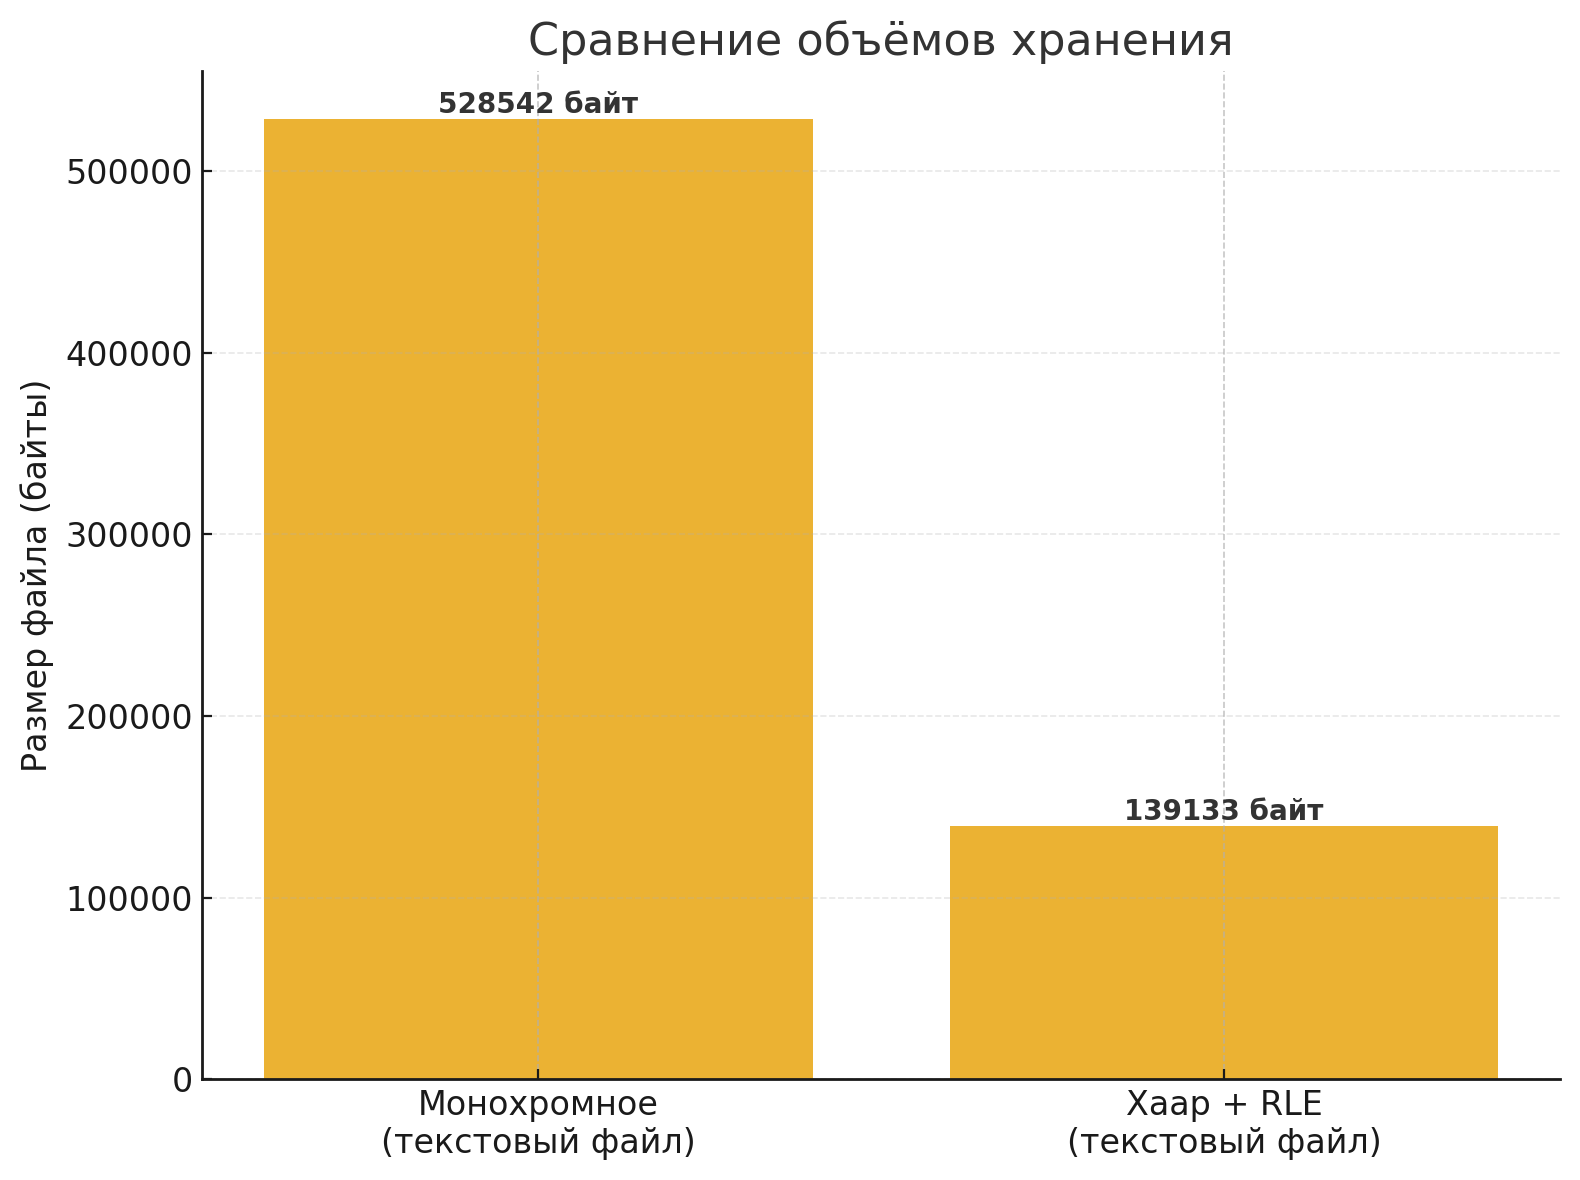

In [7]:
# 5. Сравнение объёмов памяти для исходного и сжатого представления

# Размер текстового файла с монохромным изображением
with open('monochrome_image.txt', 'r', encoding='utf-8') as f:
    original_size = len(f.read().encode('utf-8'))

# Размер текстового файла с компонентами Хаара и RLE
with open('haar_components.txt', 'r', encoding='utf-8') as f:
    compressed_size = len(f.read().encode('utf-8'))

print(f'Размер файла с монохромным изображением: {original_size} байт')
print(f'Размер файла с компонентами Хаара + RLE: {compressed_size} байт')
if compressed_size > 0:
    print(f'Коэффициент сжатия: {original_size / compressed_size:.2f}')

# Визуализация сравнения размеров файлов
sizes = [original_size, compressed_size]
labels = ['Монохромное\n(текстовый файл)', 'Хаар + RLE\n(текстовый файл)']

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, sizes, alpha=0.8)
plt.ylabel('Размер файла (байты)')
plt.title('Сравнение объёмов хранения')
plt.grid(axis='y', alpha=0.3)

for bar, size in zip(bars, sizes):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{size} байт', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()
